## Prior CO2 cov matrix



In [75]:
from datetime import date
import xarray as xr
import numpy as np
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from global_land_mask import globe

def haversine_distance(lat, lon):
    """
    Calculate pairwise distances between points using Haversine formula.

    Parameters:
    - lat (ndarray) : 1-d array of latitude coordinates
    - lon (ndarray) : 1-d array of longitude coordinates
    Returns:
    - distances (ndarray): Pairwise distances matrix.
    """

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)

    # Compute differences in latitude and longitude
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad

    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_rad) * np.cos(lat_rad[:, np.newaxis]) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate pairwise distances in kilometers
    distances = earth_radius * c

    return distances


def create_lsm(latmin, latmax, lonmin, lonmax):
     """Creates a land-sea mask (land=1, sea=0) in 0.1 deg x 0.1 deg resolution
     for the chosen area.
     """
     lat = np.linspace(latmin,latmax, (latmax-latmin)*10)
     lon = np.linspace(lonmin,lonmax, (lonmax - lonmin)*10)
     lon_grid, lat_grid = np.meshgrid(lon,lat)
     z = globe.is_land(lat_grid, lon_grid)
     z_int = np.array(z, dtype=int)
     lsm = xr.DataArray(z_int, coords=[lat, lon], dims=["lat", "lon"])
     return lsm

def pick_area(lsm, latmin, latmax, lonmin, lonmax):
     lsm = lsm.where((latmin <= lsm.lat) & (lsm.lat <= latmax)
          &(lonmin <= lsm.lon)& (lsm.lon <= lonmax), drop=True) 
     return lsm
    

def compute_cov(lsm, sigmas, L):
    lsm_flat = lsm.stack(latlon=("lat", "lon"))

    nstate = lsm_flat.shape[0]

    #sort so that land cells first, then sea
    lsm_flat = lsm_flat.sortby(lsm_flat, ascending=False)
    #number of land gridcells = sum of land values
    nland = int(sum(lsm_flat.values))
    print(f"number of land cells: {nland}")
    #initialize cov matrix
    cov = np.zeros((nstate, nstate))
    lat = lsm_flat["lat"].values
    lon = lsm_flat["lon"].values

    #compute covariances separately for land and ocean 
    for v in ["land", "ocean"]:
        if v == "land":
            inds = [0, nland]
       
        else:
            inds = [nland, nstate]

        latv = lat[inds[0]:inds[1]]
        lonv = lon[inds[0]:inds[1]]  
        dists = haversine_distance(latv, lonv)
        sigma = sigmas[v]
        l = L[v]
        cov[inds[0]:inds[1], inds[0]:inds[1]] = sigma**2*np.exp(-1*(dists/l))
        
    return cov, lat, lon
    

def create_dataset(covariance, lat, lon):
    
    """
    Creates an xarray dataset of the covariance matrix and coordinates of the grid.
    """
    out_cov = xr.Dataset(
        data_vars={"covariance": (["nparams", "nparams"], covariance)},
        coords={"lon": (["nparams"], np.asarray(lon).flatten()),
                  "lat": (["nparams"], np.asarray(lat).flatten()),},
        attrs={'comment': f"Prior covariance for CO2 bio fluxes"}
    )
    return out_cov



# With lsm from python package global_land_mask

* i.e. what Anteneh suggested on #carbontracker channel

In [76]:


latmin = 30
latmax = 75
lonmin = -15
lonmax = 40


lsm = create_lsm(latmin, latmax, lonmin, lonmax)
#Finland - approx  latitude: 59.6 - 70.1, longitude: 19.3 -31.6

# Uncertainty (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean

#compute cov matrix and coordinates ordered so that first land then ocean
#cov, lat, lon = compute_cov(lsm_flat, sigmas, L)

In [61]:
#testing with finland bc with europe the matrix becomes too large
lsm_fin = pick_area(lsm, 59.6, 70.1, 19.3, 31.6)
cov, lat, lon = compute_cov(lsm_fin, sigmas, L)

number of land cells: 10788


In [ ]:
import matplotlib.pyplot as plt
plt.pcolormesh(cov)
plt.colorbar()

In [68]:
#check that no zeros on diagonal

print(np.count_nonzero(np.diag(cov)))
print(np.diag(cov).shape)

12915
(12915,)


In [51]:
lsm_eur

<xarray.DataArray (lat: 450, lon: 550)>
array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 30.07 30.17 30.27 30.37 ... 74.69 74.79 74.89 74.99
  * lon      (lon) float64 -14.95 -14.85 -14.75 -14.65 ... 39.76 39.86 39.96

In [77]:
lsm

<xarray.DataArray (lat: 450, lon: 550)>
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 74.6 74.7 74.8 74.9 75.0
  * lon      (lon) float64 -15.0 -14.9 -14.8 -14.7 -14.6 ... 39.7 39.8 39.9 40.0

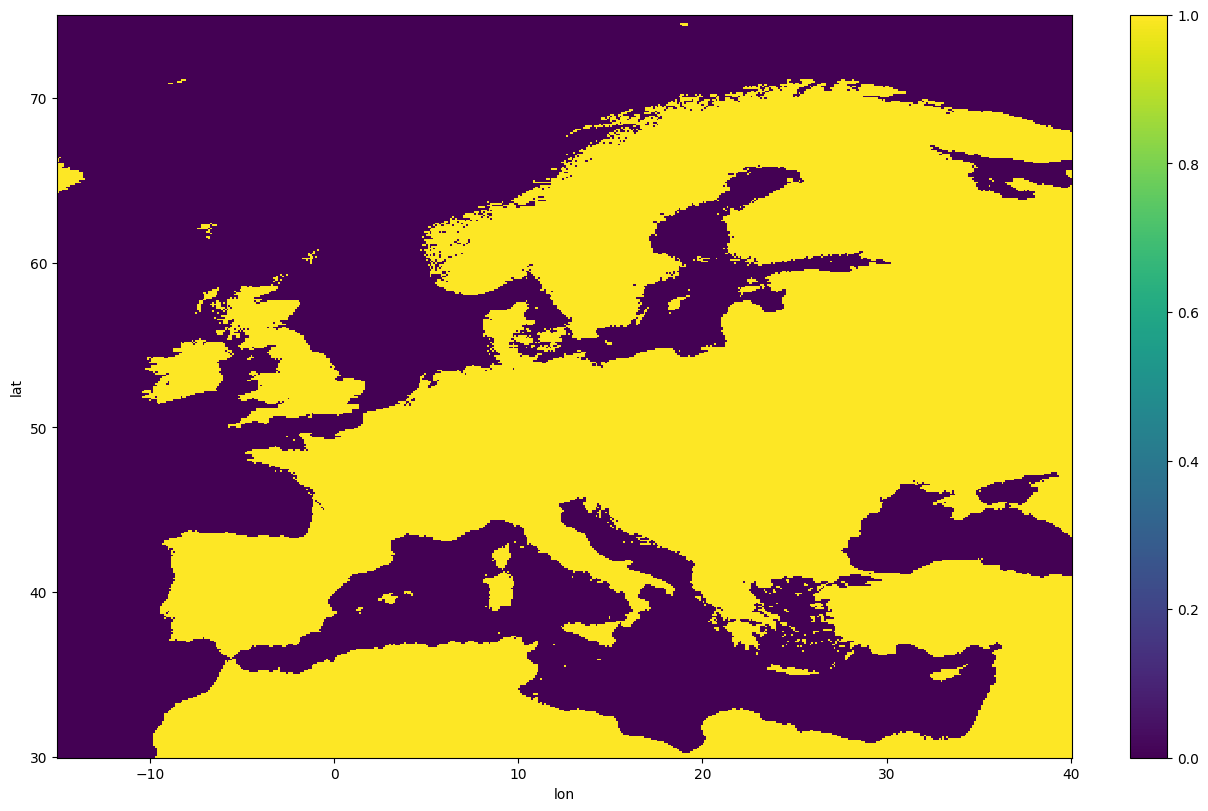

In [78]:
fig, ax = plt.subplots(figsize= (12,8), layout="constrained")
lsm.plot.pcolormesh()

# With lsm from ERA5-Land

In [42]:


#land-sea-mask_0.1x0.1deg
PATHTOMASK = '/home/pietaril/Documents/data/masks'

lsm = xr.open_dataset(os.path.join(PATHTOMASK, "lsm_1279l4_0.1x0.1.grb_v4_unpack.nc"))["lsm"][0]
clake = xr.open_dataset(os.path.join(PATHTOMASK, "clake.nc"))["cl"][0]
#change longitude coordinates from 0:360  to -180:180

lsm = lsm.assign_coords(longitude=(((lsm.longitude + 180) % 360) - 180))
clake = clake.assign_coords(longitude=(((clake.longitude + 180) % 360) - 180))
#sort  so that longitude values ascending
lsm = lsm.sortby(lsm.longitude)
clake = clake.sortby(clake.longitude)

#Finland - approx  latitude: 59.6 - 70.1, longitude: 19.3 -31.6
#Europe: lat 35-74, lon -12-39
latmin = 35
latmax = 74
lonmin= -12
lonmax = 39

#note: pick_area and compute_cov won't wotk with ERA-land mask any more as I modified them to work with Anteneh's mask instead
lsm_eur = pick_area(lsm, latmin, latmax, lonmin, lonmax)
clake_eur = pick_area(clake, latmin, latmax, lonmin, lonmax)
#flatten
lsm_eur_flat = lsm_eur.stack(latlon=("latitude", "longitude"))

# Uncertainty (std)
sigmas = {'land': 0.8,
          'ocean': 1.2} 


# Correlation length (km)
L = {'land': 100,  # 
     'ocean': 500}  # for ocean

#compute cov matrix and coordinates ordered so that first land then ocean
#cov, lat, lon = compute_cov(lsm_flat, sigmas, L)



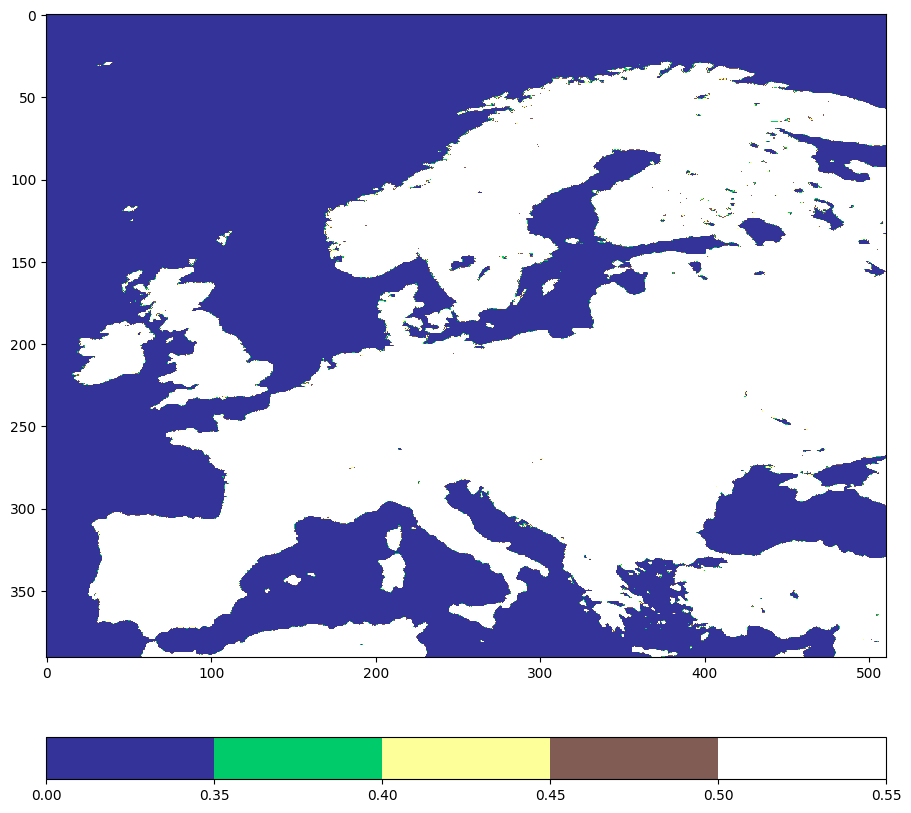

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 11), layout='constrained')


bounds = [0., 0.35, 0.4, 0.45,  0.5, 0.55]
pcm = ax.imshow(lsm_eur, norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither'), cmap='terrain')
fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

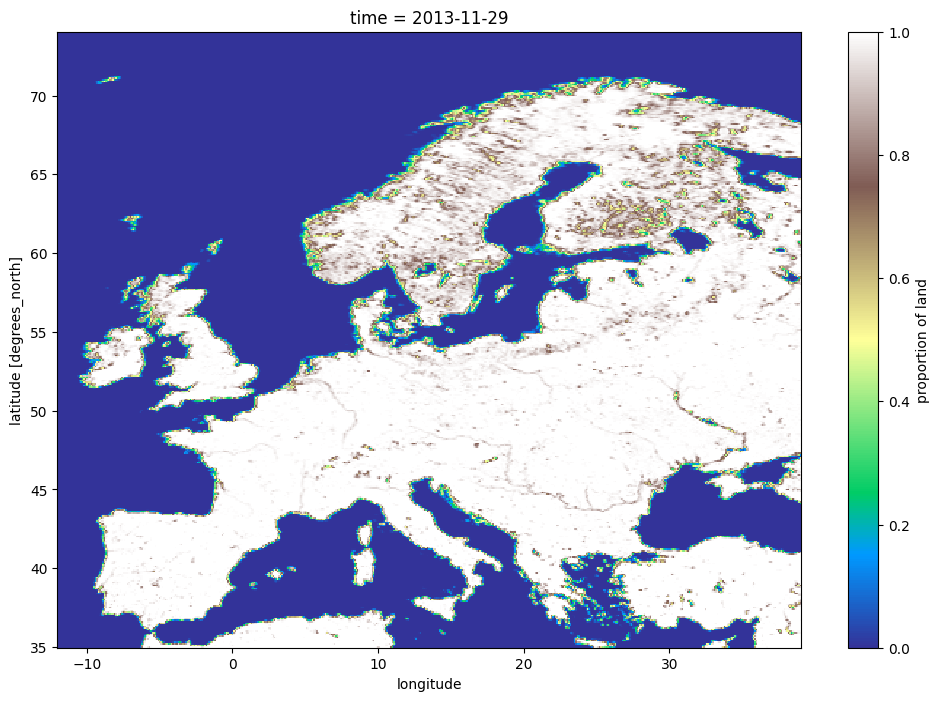

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
pcm = lsm_eur.plot.pcolormesh(ax = ax, cmap = "terrain", cbar_kwargs={"label": "proportion of land"})


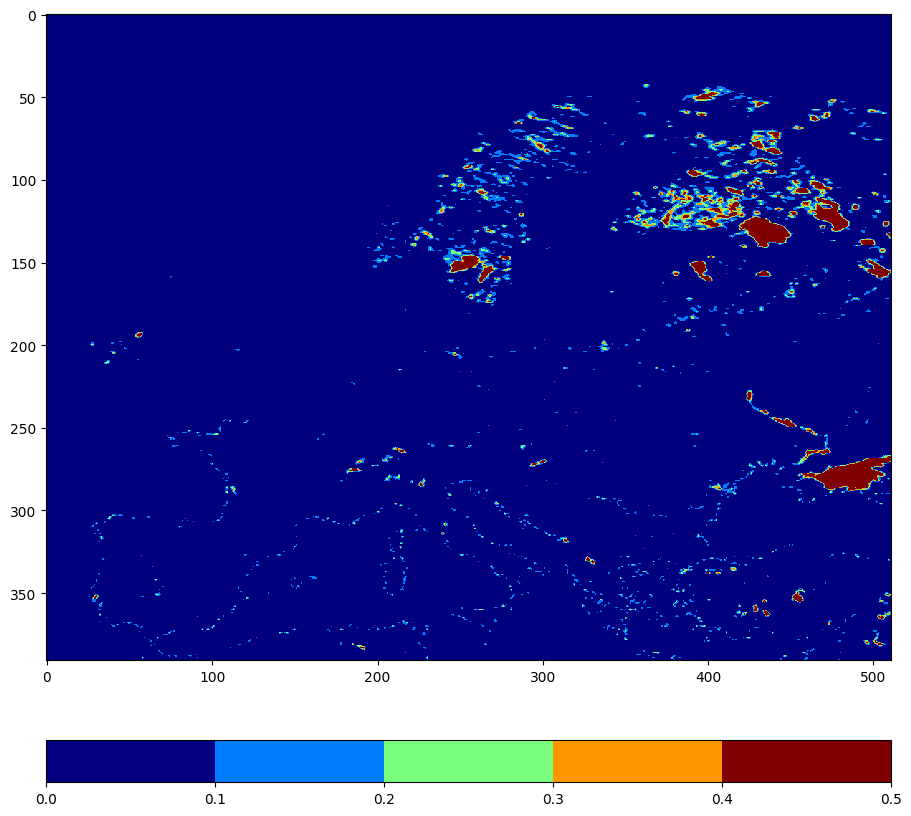

In [38]:
fig, ax = plt.subplots(figsize=(9, 11), layout='constrained')
bounds = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
pcm = ax.imshow(clake_eur, norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither'), cmap='jet')
fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

In [ ]:
#from Laia's auxiliary plot-function. I haven't modified this yet enough to work with my codes/data


fig, ax = plt.subplots(figsize=(12, 8), edgecolor='k', subplot_kw={'projection': projection})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
    ax.set_extent(aoi)
    ax.set_title(title1, fontsize=18)

    if len(data1.shape) == 1:
    # use scatter plot
    sc = ax.scatter(lon, lat, c=data1, cmap='viridis', transform=projection, s=0.85, alpha=1)
    plt.colorbar(sc, orientation='vertical')
    else:
    # use pcolormesh
    mesh = ax.pcolormesh(lon, lat, data1, cmap='viridis', transform=projection, alpha=0.7)
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label(label1)

Text(0.5, 0.98, 'Proportion of land treshold 0.5')

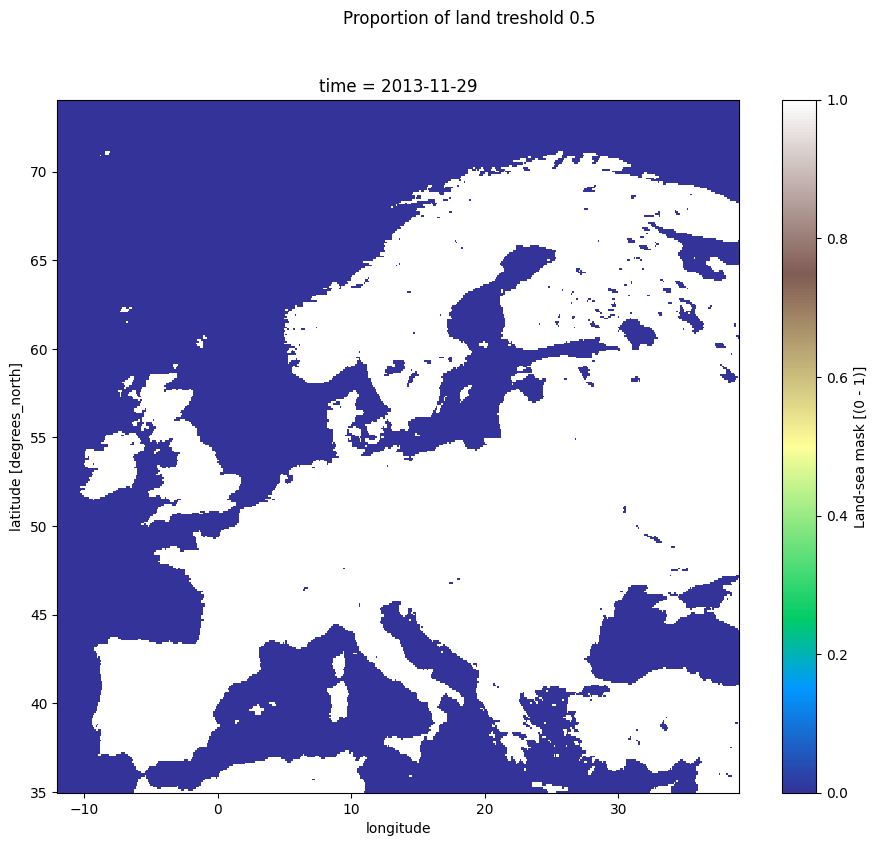

In [45]:

fig, ax = plt.subplots(figsize = (11,9))
lsm_eur_bin.plot.pcolormesh(ax = ax, cmap="terrain")
plt.suptitle(f"Proportion of land treshold {prop_land}")

In [ ]:

# Output dataset

OUTPUT_PATH = '/home/pietaril/Documents/data/unc_cov_matrices'
today = date.today()
output_filename = 'CO2_prior_cov_fin_%04d%02d.nc' % (today.year, today.month)
out_cov = create_dataset(cov, lat, lon)
out_cov.to_netcdf(os.path.join(OUTPUT_PATH, output_filename))


In [6]:

i_lower = np.tril_indices(nr, -1) # lower triangular indices (excluding the diagonal)
cov[i_lower] = cov.T[i_lower]

cov = finalize(cov, sigmas)
dof = check(cov)
out_cov = write_dataarray(out_cov, cov, vv, nr, dof)

out_cov.to_netcdf('%s_cov.nc' % wfile.split('.nc')[0])


10605

In [60]:
cov.shape

AttributeError: 'tuple' object has no attribute 'shape'

12915

In [65]:
np.diag(cov).shape


(12915,)

* notes on tablet on how the CH4 priors constructed